# School objective functions

Max Kapur | [maxkapur.com](https://www.maxkapur.com/)

*N.B.* This is a working document, more of a set of personal notes than a finished product. Please see my other Github repositories or the paper included in this repo for somewhat more polished discussions of admissions markets.

------

Previous research has dodged the notion of school objective functions because it is hard to define a total ordering over the set of sets of students. However, it is worth considering what forms such objective functions could take, and attempting to inverse optimize for their parameters.

The possible "ingredients" of a school objective function are the cutoff $p$, the demand $D$, and the integral of scores over the set of admitted students $L$. $D$ and $L$ are functions of $p$. As argued in the paper, $L$ is shaped much like $D$, but lacks its desirable property of convexity, so I will disregard $L$ here. And $D$ is a function of $p$, so ultimately our school objectives $u_c$ will be too.

The objective function should be increasing in $p$ and $D$, and it would be nice to have a parameter $\sigma$ that expresses the school's preference for "selectivity" over "large class size."

It is apparent from the shape of the demand curve that a linear form such as $u_c= D_c + \sigma p_c$ is unsuitable. Then the optimum will *always* occur at $p=0$ or $p=1$ (or both, in an edge case). 

Instead, consider the *product* $D_c \cdot p_c^{\sigma}$, which can have its optimum anywhere on the open segment. Taking the log, it suffices to assume each school wants to maximize the following utility function:

$$u_c(p_c) = \log D_c + \sigma \log p_c$$

In this notebook, I show that this form of the utility function allows us to capture the heterogeneous behavior of schools in selecting their cutoffs. Although nonconcave, it is piecewise concave in a finite number of pieces, so finding the maximum is quite easy. It is also differentiable, so we can dream up a variety of iterative strategies. 

In [132]:
push!(LOAD_PATH, pwd())
using OneTest

using Plots, Plots.PlotMeasures
# using LaTeXStrings
using LinearAlgebra
# import DeferredAcceptance: deferredacceptance

## Pallet Town

We will use the toy market of Pallet Town to check out the shape of some objective functions. 

In [2]:
ptown = Market(log.([1, 3, 2, 6]), [0.1, 0.2, 0.3, 0.2]) |> sort
p_star = equilibrium(ptown)

4-element Vector{Float64}:
 0.19999999999999996
 0.29999999999999993
 0.39999999999999997
 0.6

In [298]:
ptown.gamma

4-element Vector{Float64}:
 2.0
 1.0
 3.0000000000000004
 6.0

Since we are using the same kind of `Market` struct, it has a capacity built in. However, this isn't relevant to the notion of equilibrium considered here; instead we care about the taste parameters $\sigma$. Below, I have just picked some random numbers; in this case, the market-clearing equilibrium for school 2 *also* happens to optimize its utility function, but this doesn't hold for the other schools.

In [299]:
sigma = [0.9, 1.0, 3.0, 0.5]

4-element Vector{Float64}:
 0.9
 1.0
 3.0
 0.5

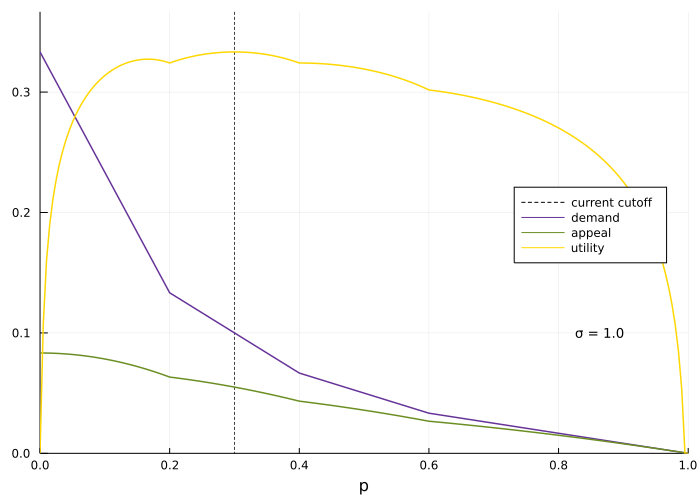

In [365]:
"""
    utility(market, sigma, p)

Gives the value of each school's objective function ``u_c(p_c) = \\log D_c + σ \\log p_c``.
"""
function utility(market::Market, sigma::Union{<:AbstractFloat, Vector{<:AbstractFloat}}, p::Vector{<:AbstractFloat})
    return log.(demand(market, p)) .+ sigma .* log.(p)
end

function plotdemandcurve(market::Market, c::Int; p_fix=nothing, st=0.005, sigma=1)
    if p_fix === nothing
        p_fix = equilibrium(market)
    end
    
    p_try = 0:st:1
    
    dem = zeros(length(p_try))
    app = zeros(length(p_try))
    
    for (i, pc) in enumerate(p_try)
        p = copy(p_fix)
        p[c] = pc
        dem[i] = demand(market, p)[c]
        app[i] = appeal(market, p)[c]
    end
    
    utility = log.(dem[2:end-1]) + sigma * log.(p_try[2:end-1])
    
    # Just some affine scaling to make plot legible
    utility .-= minimum(utility)
    utility ./= maximum(utility)
    utility .*= maximum(dem)

    utility = [0, utility..., 0]

    pl = plot(xlim = (0, 1), xlabel="p", ylim=(0, 1.1*maximum(dem)), size=(700, 500), legend=:right)


    vline!([p_fix[c]], color=:black, ls=:dash, lw=.75, label="current cutoff")
    plot!(p_try, dem, color=:rebeccapurple, lw=1.5, label="demand")
    plot!(p_try, app, color=:olivedrab, lw=1.5, label="appeal")
    plot!(p_try, utility, color=:gold, lw=1.5, label="utility")

    sigma = round(sigma, digits=3)
    annotate!([(0.9, 0.1, text("σ = $sigma", 9, :right))])
        
    return pl
end

plotdemandcurve(ptown, 2, sigma=1)

┌ Info: Saved animation to 
│   fn = C:\Users\Max\OneTest\tmp.gif
└ @ Plots C:\Users\Max\.julia\packages\Plots\kyYZF\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Max\\OneTest\\tmp.gif")
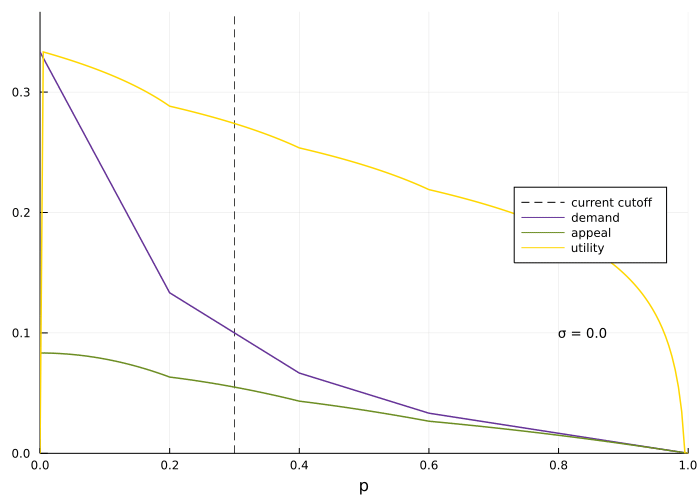

In [362]:
function plotdemandcurve_anim(market::Market, c::Int; p_fix=nothing, st=0.005)
    if p_fix === nothing
        p_fix = equilibrium(market)
    end
    
    p_try = 0:st:1
    
    dem = zeros(length(p_try))
    app = zeros(length(p_try))
    
    for (i, pc) in enumerate(p_try)
        p = copy(p_fix)
        p[c] = pc
        dem[i] = demand(market, p)[c]
        app[i] = appeal(market, p)[c]
    end
    
    ran = 2 .^(-5:0.2:7)
    pl = @animate for sigma in vcat(0, ran, reverse(ran)[2:end])

        utility = log.(dem[2:end-1]) + sigma * log.(p_try[2:end-1])

        # Just some affine scaling to make plot legible
        utility .-= minimum(utility)
        utility ./= maximum(utility)
        utility .*= maximum(dem)
        
        utility = [0, utility..., 0]

        plot(xlim = (0, 1), xlabel="p", ylim=(0, 1.1*maximum(dem)), size=(700, 500), legend=:right)


        vline!([p_fix[c]], color=:black, ls=:dash, lw=.75, label="current cutoff")
        plot!(p_try, dem, color=:rebeccapurple, lw=1.5, label="demand")
        plot!(p_try, app, color=:olivedrab, lw=1.5, label="appeal")
        plot!(p_try, utility, color=:gold, lw=1.5, label="utility")
        
        sigma = round(sigma, digits=2)
        annotate!([(0.8, 0.1, text("σ = $sigma", 9, :left))])
    end

    return pl
end

gif(plotdemandcurve_anim(ptown, 2), fps=15)

## Reverse optimization of school objective functions

The animation above suggests that as expected, the location of the optimum increases continuously from just above zero to just below one as $\sigma$ varies from just above zero to nearly infinity. 

This means that given the equilibrium cutoff of a given school and the demand function, we can use a secant method to find the value of $\sigma$ for which the school's chosen cutoff is optimal. This will be different than the values of $\sigma$ given above, although we can see from the graph that $\sigma_2 = 1$. 

In [366]:
# In progress, July 5, 2021. 

## Incentive gradients and local equilibrium search

With $u_c(p_c) = \log D_c + \sigma \log p_c$, we have $$u'_c(p_c) = \frac{1}{D_c} D'_c + \frac{\sigma}{p_c} = \frac{1}{A_{c.} p + \frac{1}{\Gamma}\gamma_c} A_{cc} + \frac{\sigma}{p_c}$$

where $A$ is the demand matrix given in the paper, and $p$ is sorted.

In [178]:
"""
   incentivegradient(market, sigma, cutoffs)

When each school's objective function is ``u_c(p_c) = \\log D_c + σ \\log p_c``,
gives the gradient of each school's objective with respect to its own cutoff.
"""
function incentivegradient(mkt::Market, sigma, p)
    A, sort_order = demandmatrix(mkt, p)
    
    grad = zeros(length(mkt))
    grad[sort_order] = diag(A) ./ demand(mkt, p)[sort_order] .+ sigma[sort_order] ./ p[sort_order]
    
    return grad
end


incentivegradient(ptown, sigma, p_star)

4-element Vector{Float64}:
  1.1666666666666674
  8.881784197001252e-16
  5.000000000000001
 -1.666666666666666

If the market is well-behaved, we can find local equilibria by following the incentive gradient at each school. Because the objective functions are not convex, these will only be local. Also, the derivative is undefined when $p = 0$ or $p=1$, so it is useful to use clamping to avoid these extremes.

In [359]:
function localequilibriumsearch(mkt, sigma; maxit::Int=50, p0=nothing, rate=.005, damping=.2)
    if p0===nothing
        p = rand(length(mkt))
    else
        p = p0
    end
    
    res = Vector[]
    clamp = 1e-4
    
    for it in 1:maxit 
        push!(res, p)
        grad = incentivegradient(mkt, sigma, p)
        p = min.(1 - clamp, max.(clamp, p + rate * grad / it^damping))
    end
    
    return res
end
    
iterates = localequilibriumsearch(ptown, sigma; maxit=100, p0=fill(.5, length(ptown)))
@show iterates[end]

iterates[end] = 

4-element Vector{Float64}:
 0.21597186819486297
 0.27386735447571464
 0.7479015589876018
 0.3417275221373379

[0.21597186819486297, 0.27386735447571464, 0.7479015589876018, 0.3417275221373379]


┌ Info: Saved animation to 
│   fn = C:\Users\Max\OneTest\tmp.gif
└ @ Plots C:\Users\Max\.julia\packages\Plots\kyYZF\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Max\\OneTest\\tmp.gif")
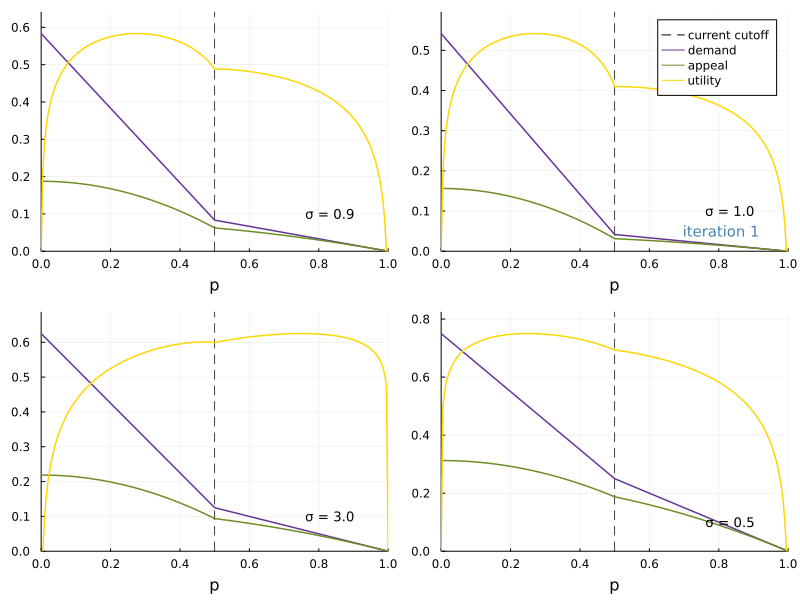

In [356]:
function plotiterates(market, sigma, iterates, st=0.005)
    p_try = 0:st:1
    
    res = @animate for (j, p_fix) in enumerate(iterates)
        pl = plot(layout=length(market), size=(800, 600))
        
        for c in 1:length(market) 

            dem = zeros(length(p_try))
            app = zeros(length(p_try))

            for (i, pc) in enumerate(p_try)
                p = copy(p_fix)
                p[c] = pc
                dem[i] = demand(market, p)[c]
                app[i] = appeal(market, p)[c]
            end
            
            utility = log.(dem[2:end-1]) + sigma[c] * log.(p_try[2:end-1])

            # Just some affine scaling to make plot legible
            utility .-= minimum(utility)
            utility ./= maximum(utility)
            utility .*= maximum(dem)

            utility = [0, utility..., 0]

            plot!(pl, xlim = (0, 1), xlabel="p", ylim=(0, 1.1*maximum(dem)), legend=:none, subplot=c)

            vline!(pl, [p_fix[c]], color=:black, ls=:dash, lw=.75, label="current cutoff", subplot=c)
            plot!(pl, p_try, dem, color=:rebeccapurple, lw=1.5, label="demand", subplot=c)
            plot!(pl, p_try, app, color=:olivedrab, lw=1.5, label="appeal", subplot=c)
            plot!(pl, p_try, utility, color=:gold, lw=1.5, label="utility", subplot=c)

            s = round(sigma[c], digits=3)
            annotate!(pl, [(0.9, 0.1, text("σ = $s", 9, :right))], subplot=c)
            
        end
        
        plot!(pl, legend=:topright, subplots=2)
        annotate!(pl, [(0.7, 0.05, text("iteration $j", 10, :left, :steelblue))], subplots=2)
    end
    
    return res
end

gif(plotiterates(ptown, sigma, iterates), fps=10)

Looking at school 3 (top right pane), we can see there is a globally better choice at $p \approx 0.17$, whereas this method has settled on a local maximum. 

## Best-response dynamics and global equilibrium search

Next, let's consider a best-response dynamics scheme where each school changes its cutoff to its global maximum on the assumption that other schools stay in the same place. 

Although the utility functions aren't concave, they are composed of concave segments, so it suffices to do line search within each segment and report the overall best.

Helpfully, we also have gradient info, so we can use the secant method to solve the equation $u_c'(p_c) = 0$ for $p_c$ on the segment.

In [291]:
# const phi = (-1 + √5)/2
# const omp = (3 - √5)/2 # One minus phi
phi = (-1 + √5)/2
omp = (3 - √5)/2 # One minus phi

"""
    goldensection(f, lb, ub, nit)

Computes the maximizer of `f` on the interval `(lb, ub)` by the method of golden
sections. Uses `nit` iterations.
"""
function goldensection(f::Function, lb, ub, nit=25)
    for i in 1:nit
        a = lb + omp*(ub - lb)
        b = lb + phi*(ub - lb)

        if f(a) < f(b)
            lb = a
        else
            ub = b
        end
    end
    
    return (lb + ub) / 2
end
    

goldensection

iterates[end] = [0.4440786039224989, 0.17739667447205054, 0.7499995718411684, 0.27595011056736163]


┌ Info: Saved animation to 
│   fn = C:\Users\Max\OneTest\tmp.gif
└ @ Plots C:\Users\Max\.julia\packages\Plots\kyYZF\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Max\\OneTest\\tmp.gif")
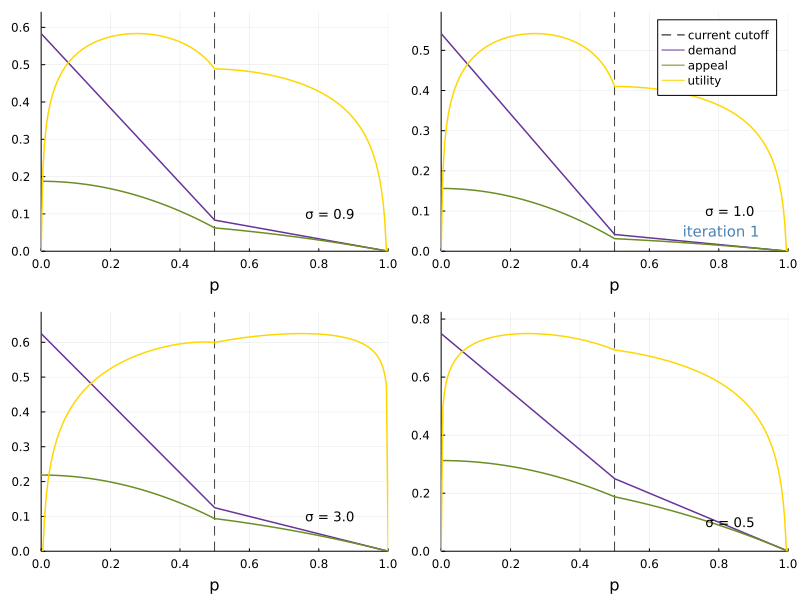

In [361]:
function bestresponse(market, sigma, p_curr=nothing, nit=10)
    if p_curr===nothing
        p_curr = rand(length(mkt))
    end
    
    res = Vector[p_curr]
    
    for j in 1:nit
        p_next = zeros(length(p_curr))
        for c in 1:length(market)
            p_intervals = copy(p_curr)
            deleteat!(p_intervals, c)
            
            function u(x)
                p = copy(p_curr)
                p[c] = x
                return utility(market, sigma, p)[c]
            end

            p_next[c] = argmax(u, goldensection(u, lb, ub) for (lb, ub) in zip((0, p_intervals...), (p_intervals..., 1)))
        end
        
        p_curr = copy(p_next)
        push!(res, p_curr)
    end
    
    return res
end

iterates = bestresponse(ptown, sigma, fill(0.5, 4))
@show iterates[end]
gif(plotiterates(ptown, sigma, iterates), fps=3)

In [342]:
goldensection(f, 0, 0.5)

1.4902152466372853e-6

In [345]:
f(0.0007)

-3.108739112291951

In [294]:
goldensection(f, 2, 4)

2.0000059608609866

In [314]:
zip((0, [1, 2, 4]...), (0, [3, 4, 5]...)) |> collect

4-element Vector{Tuple{Int64, Int64}}:
 (0, 0)
 (1, 3)
 (2, 4)
 (4, 5)

In [289]:
phi + omp

1.0